In [1]:
import xarray as xr
import pandas as pd
import numpy as np
import calendar as cld
import matplotlib.pyplot as plt
import matplotlib.colors
colors_land = plt.cm.terrain(np.linspace(0.25, 1, 256))
import proplot as pplt # New plot library (https://proplot.readthedocs.io/en/latest/)
pplt.rc['savefig.dpi'] = 300 # 1200 is too big! #https://proplot.readthedocs.io/en/latest/basics.html#Creating-figures
from scipy.stats import chi2
from numba import njit,prange
import matplotlib as mpl
mpl.rcParams['hatch.linewidth'] = 0.05  # previous pdf hatch linewidth
from matplotlib.dates import DateFormatter

In [2]:
normal_format = {'gridlinewidth':0.1, 'gridcolor':'gray8', 'gridalpha':0.5, 'coast':True,'borders':True ,'reso':'hi', 'labels':True, 'lonlines':2, 'latlines':2, 'abc':False, 'latlim':[43.,48.5],'lonlim':[4.,16.]}
multiplot_format = {'gridlinewidth':0.1, 'gridcolor':'gray8', 'gridalpha':0.5, 'coast':True,'borders':True ,'reso':'hi', 'labels':False, 'lonlines':2, 'latlines':2, 'abc':False, 'latlim':[43.,48.5],'lonlim':[4.,16.]}

imin = 32 ; imax = -30
jmin = 20 ; jmax = -15
ds = xr.open_dataset('/bettik/beaumetj/MARout/MAR-ERA-20C/MARgrid_EUf.nc')
lon = np.array(ds.LON[jmin:jmax,imin:imax])
lat = np.array(ds.LAT[jmin:jmax,imin:imax])
H = np.array(ds.SH[jmin:jmax,imin:imax])
nlat,nlon = 91, 139

In [3]:
def detect_alps(H):
    nlat,nlon = np.shape(H)
    mask = np.bool8(np.zeros((nlat,nlon)))
    r = 4
    for j in range(r,nlat-r):
        for i in range(r,nlon-r):
            mask[j,i] = np.logical_and(H[j,i]>360 ,np.any(H[j-r:j+r,i-r:i+r]>1300))
            # mask[j,i] = np.std(H[j-r:j+r,i-r:i+r])>200
    return mask
alps = detect_alps(H)
alps[lon<4.8] = False
alps[np.logical_and(lon>10,lat<45.2)] = False

north_french_alps = np.copy(alps)
north_french_alps[lon>7] = False
north_french_alps[lat<44.5] = False
north_french_alps[lat>46.5] = False

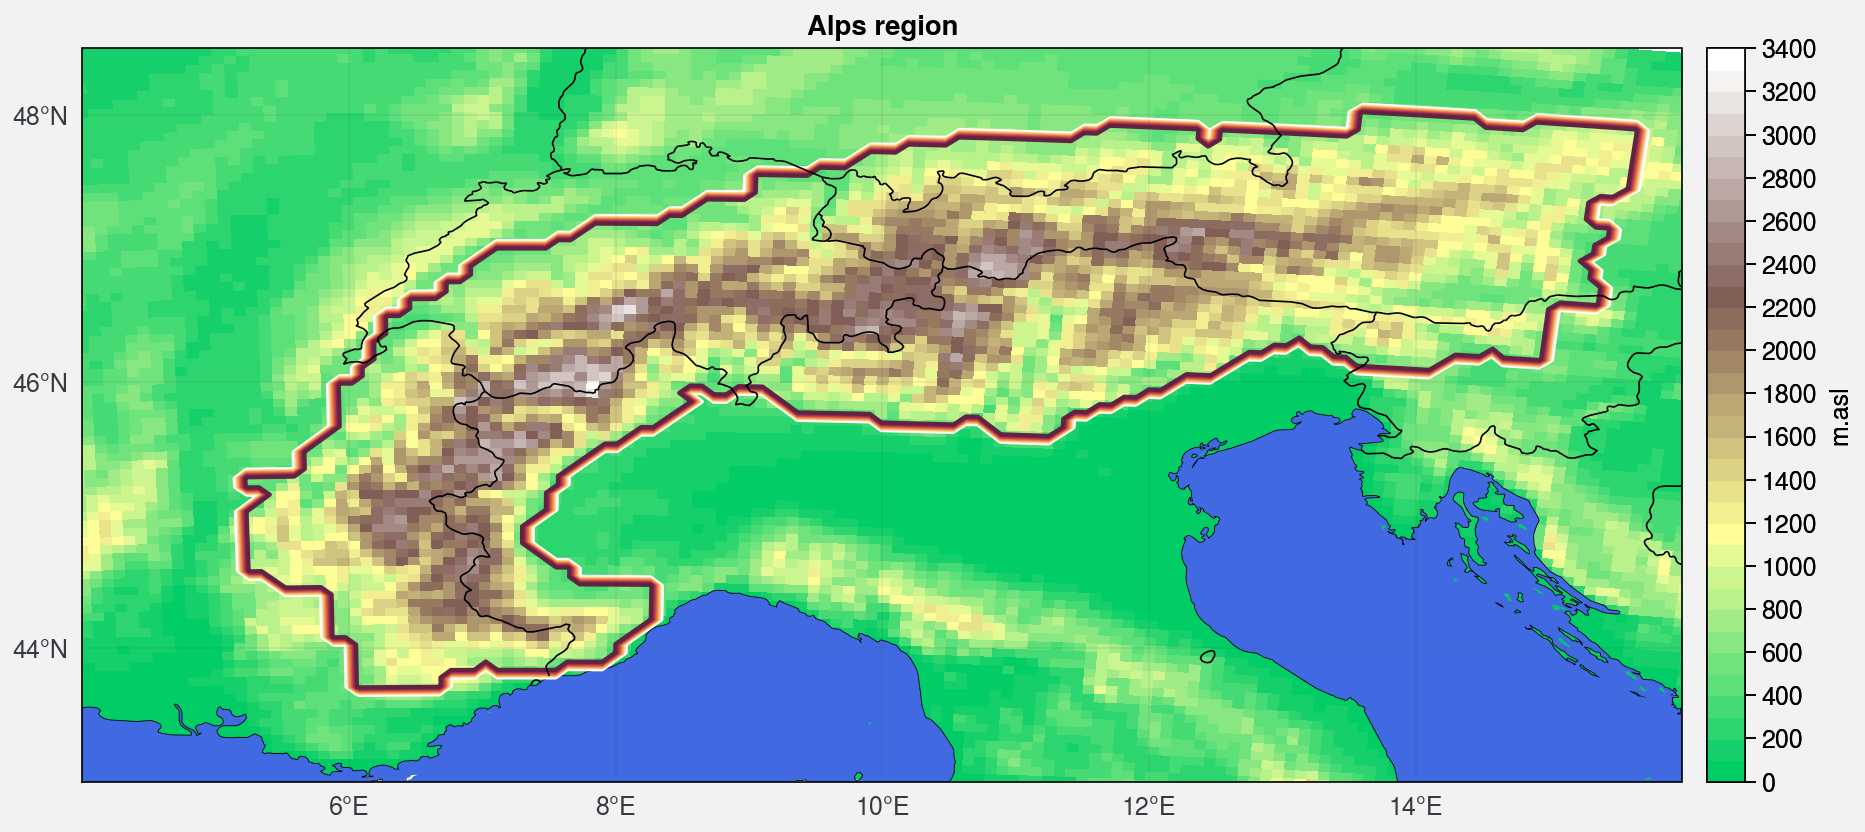

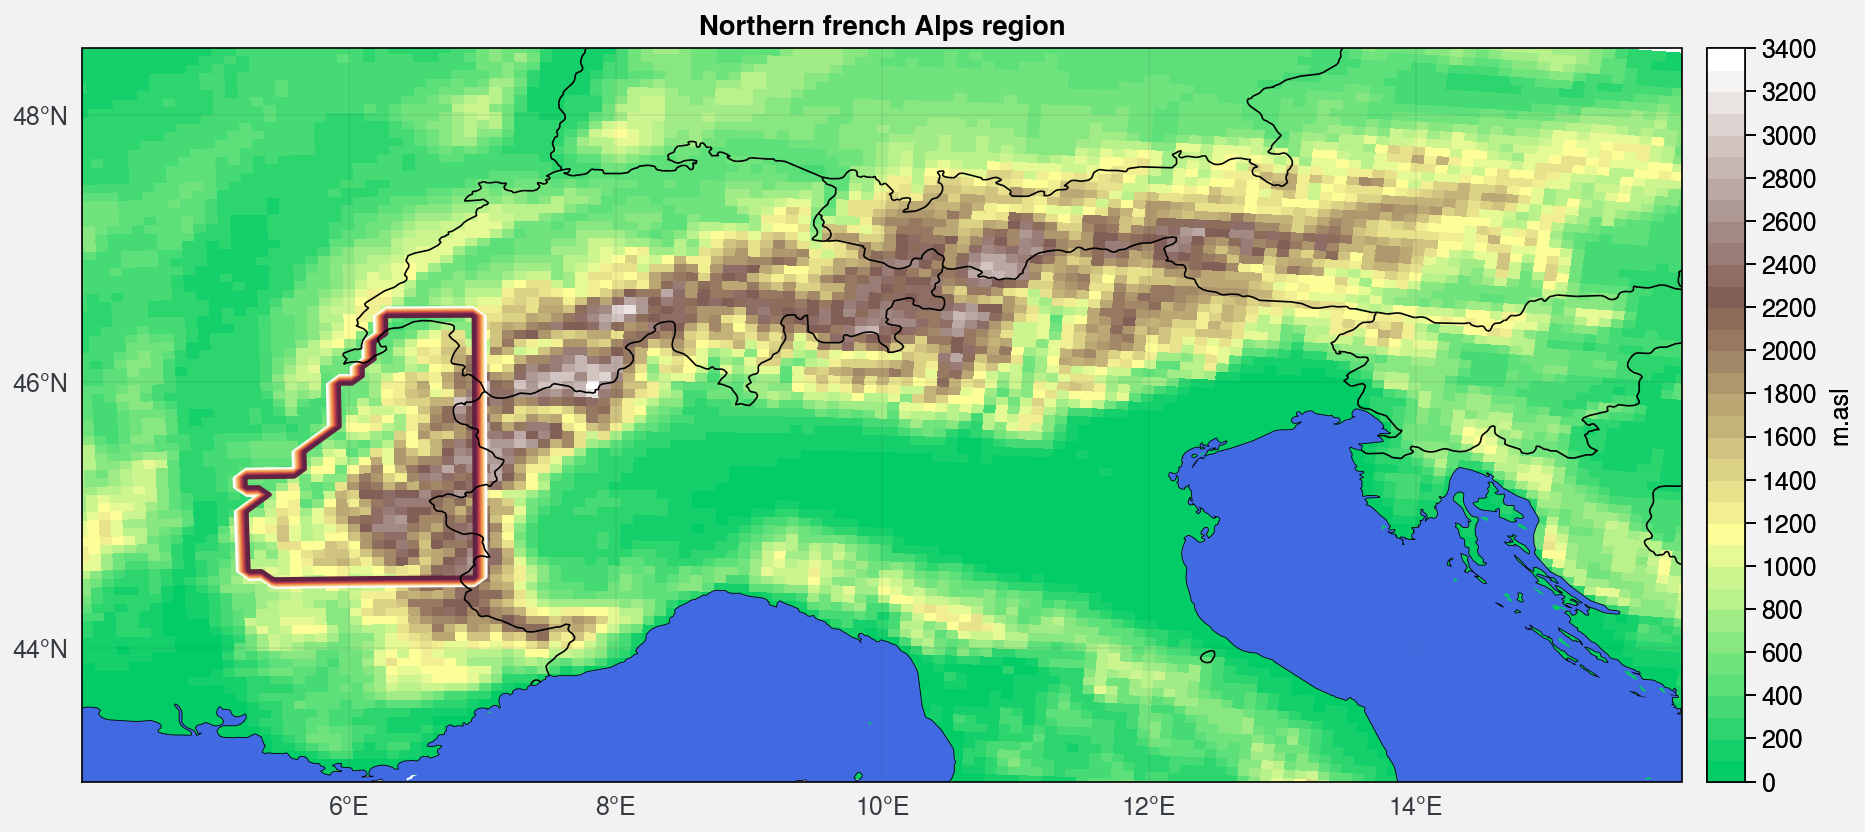

In [4]:
f, ax = pplt.subplots(proj='cyl', axwidth=8)
m=ax.pcolormesh(lon, lat, H, levels=34,cmap=colors_land)
f.colorbar(m,label= 'm.asl')
ax.contour(lon, lat,alps)
# ax.contour(lon, lat,north_french_alps)

ax.format(**normal_format,suptitle='Alps region')
ax.format(ocean=True,oceancolor='royalblue',reso='hi')#, latlim=[40.,51.],lonlim=[0.,20.])


f, ax = pplt.subplots(proj='cyl', axwidth=8)
m=ax.pcolormesh(lon, lat, H, levels=34,cmap=colors_land)
f.colorbar(m,label= 'm.asl')

ax.contour(lon, lat,north_french_alps)
ax.format(**normal_format,suptitle='Northern french Alps region')
ax.format(ocean=True,oceancolor='royalblue',reso='hi')#, latlim=[40.,51.],lonlim=[0.,20.])


In [5]:
alps = north_french_alps

In [6]:
levels = [np.logical_and(alps,H<1000) , 
               np.logical_and(alps,np.logical_and(H>=1000,H<1500)),
               np.logical_and(alps,np.logical_and(H>=1500,H<2000)),
               np.logical_and(alps,np.logical_and(H>=2000,H<2500)),
               np.logical_and(alps,H>=2500),
         alps]
name_levels = ["< 1000","1000-1500","1500-2000","2000-2500","> 2500","all"]
surface_levels = np.array([np.sum(lev) for lev in levels])
frac_levels = np.array([np.sum(lev)/np.sum(alps) for lev in levels])
color_levels = [colors_land[0],colors_land[50],colors_land[100],colors_land[180],np.array([0.8,0.8,0.8,1.]),np.array([0.,0.,0.,1.]) ]
def print_rgb(rgb):
    print(rgb,end=' ')
    print(str(int(rgb[0]*255))+';'+str(int(rgb[1]*255))+';'+str(int(rgb[2]*255)),end=' ')
    print('\x1b[38;2;'+str(int(rgb[0]*255))+';'+str(int(rgb[1]*255))+';'+str(int(rgb[2]*255))+'m'+'██████'+'\x1b[0m')
for c in color_levels:
    print_rgb(c)

[0.00392157 0.80078431 0.40078431 1.        ] 1;204;102 ██████
[0.58431373 0.91686275 0.51686275 1.        ] 149;233;131 ██████
[0.90980392 0.88454902 0.55129412 1.        ] 232;225;140 ██████
[0.56078431 0.43780392 0.41145098 1.        ] 143;111;104 ██████
[0.8 0.8 0.8 1. ] 204;204;204 ██████
[0. 0. 0. 1.] 0;0;0 ██████


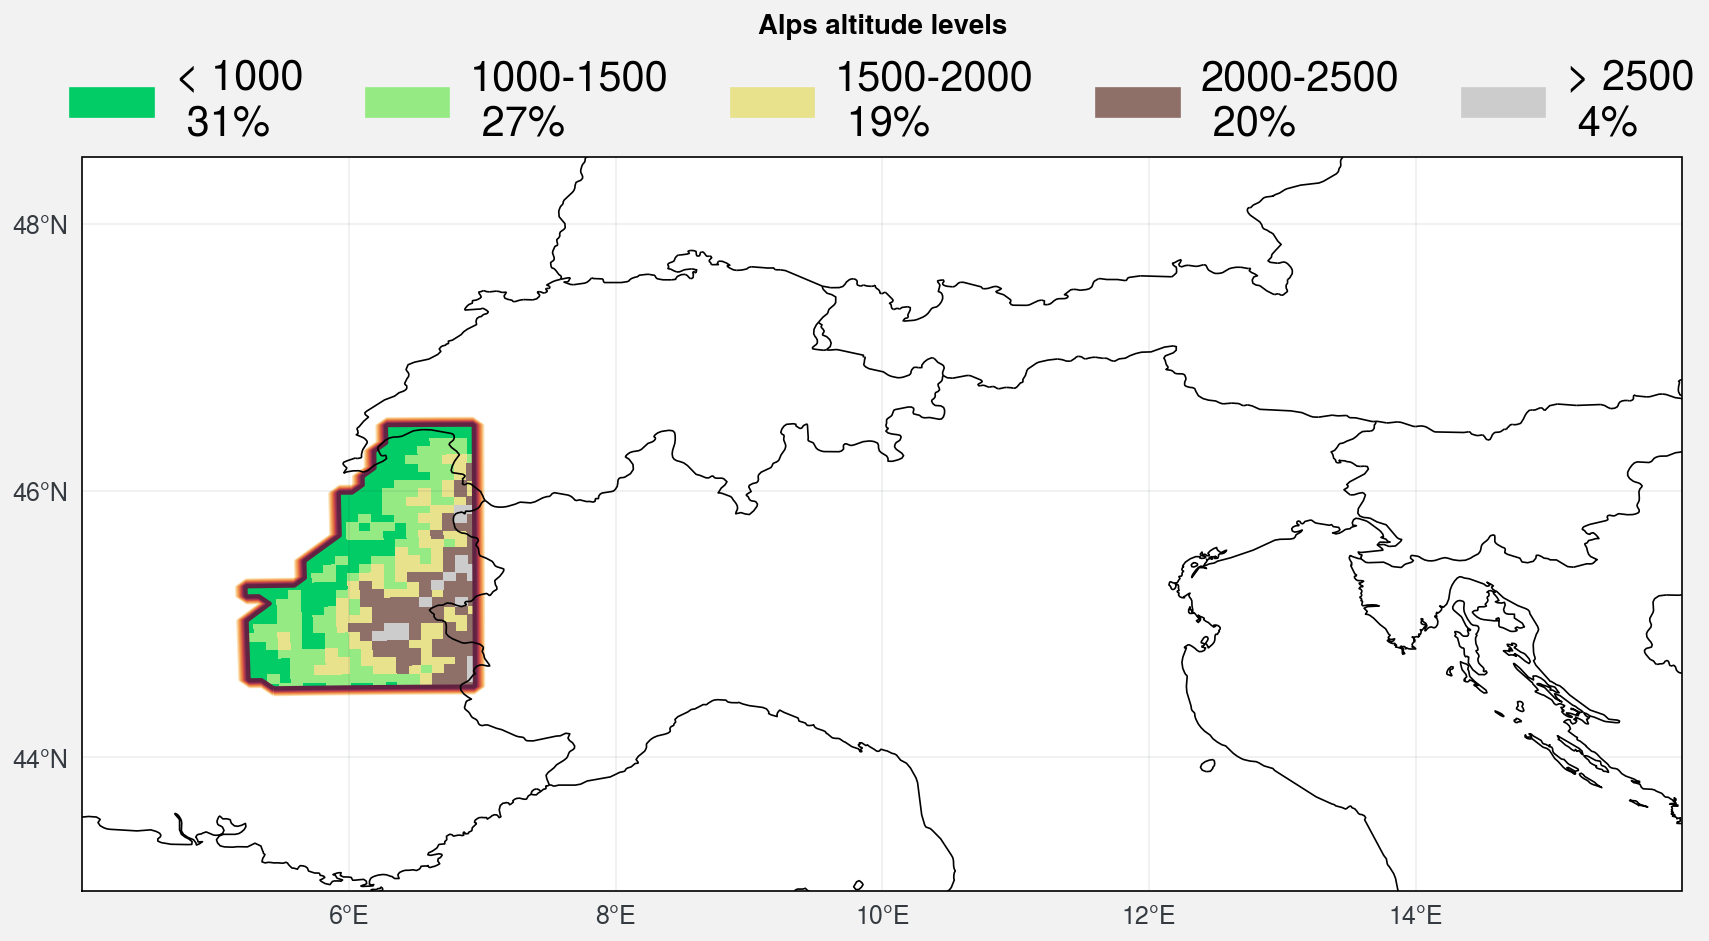

In [7]:
f, ax = pplt.subplots(proj='cyl', axwidth=8)
for i,lev in enumerate(levels[:-1]):
    ax.pcolormesh(lon, lat,np.ma.masked_array(lev,mask=np.logical_not(lev)) ,cmap=matplotlib.colors.ListedColormap([color_levels[i]]),edgecolors='none')
ax.contour(lon, lat,alps)
ax.format(**normal_format,suptitle='Alps altitude levels')
import matplotlib.patches as mpatches
ax.legend(handles=[ mpatches.Patch(color=color_levels[i],label=name_levels[i]+'\n {:.0%}'.format(np.sum(levels[i])/np.sum(alps))) for i in range(5)],
          fontsize=15, ncols=5, center=True, frame=False, loc='t')

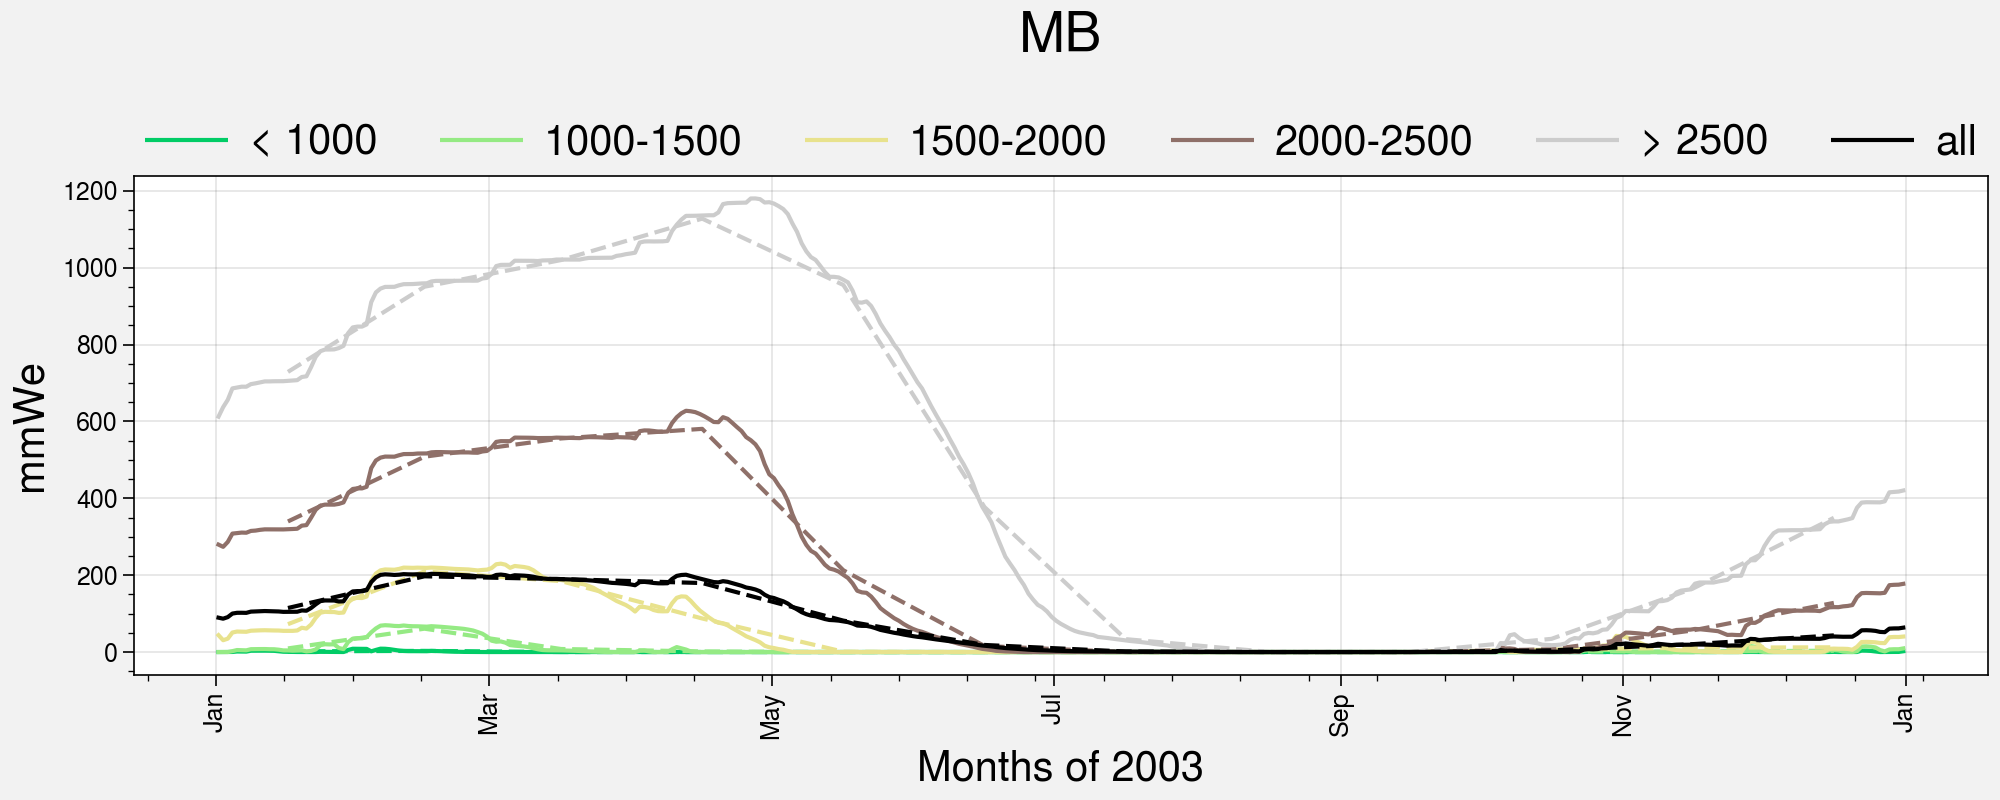

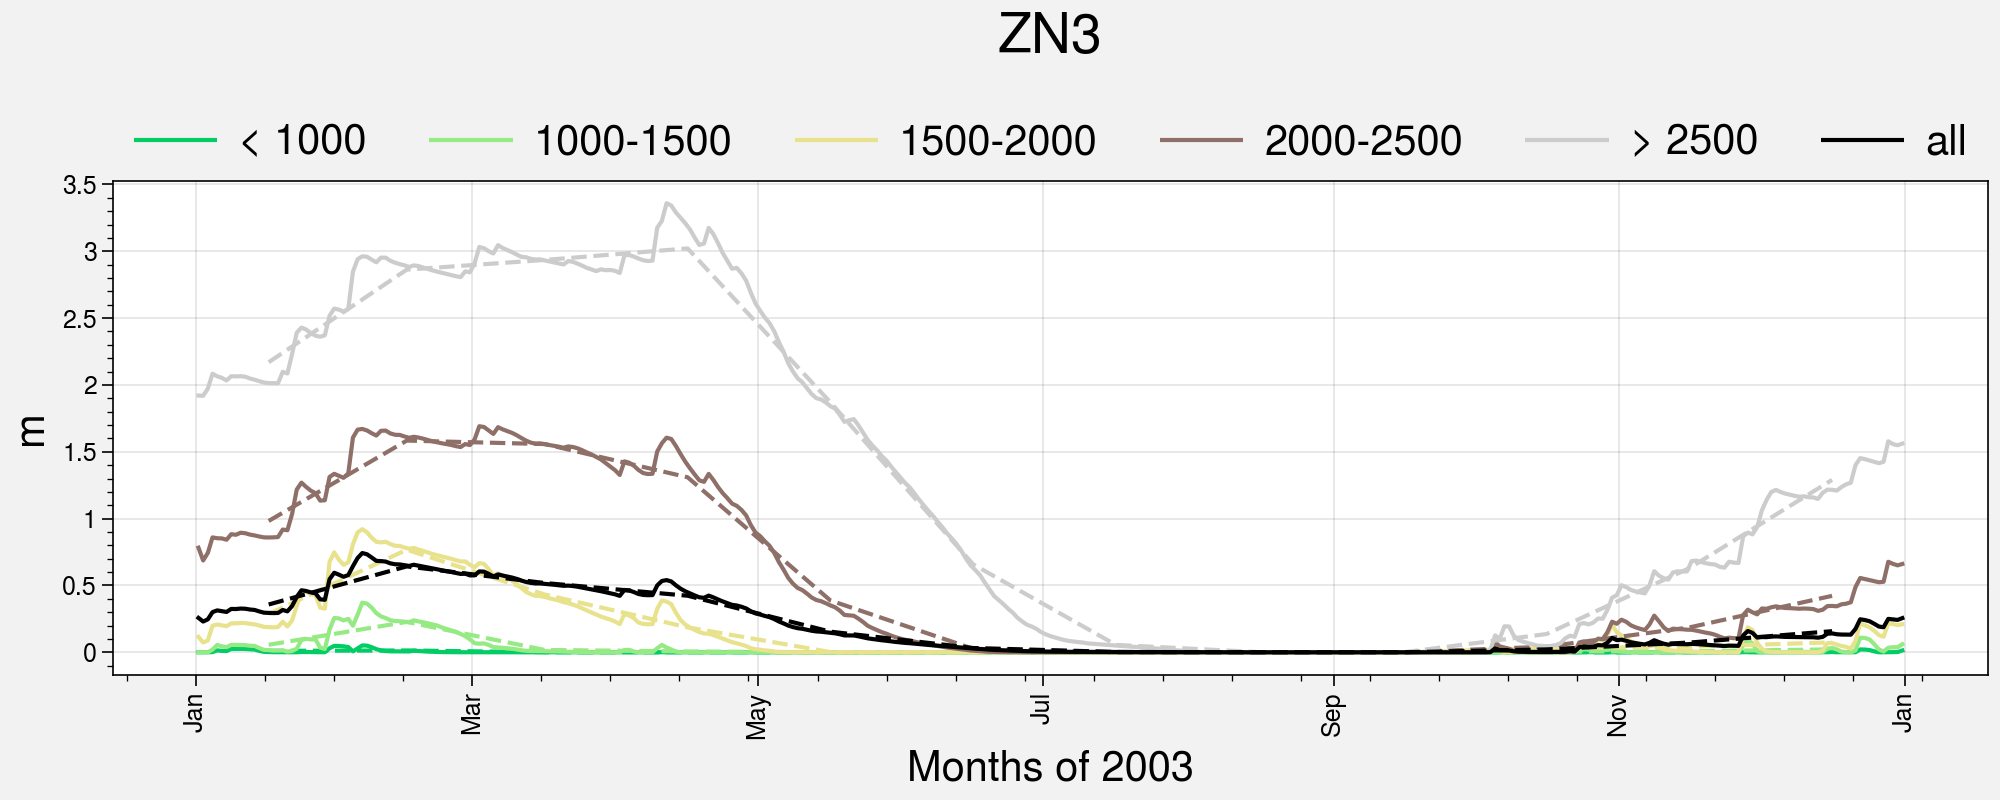

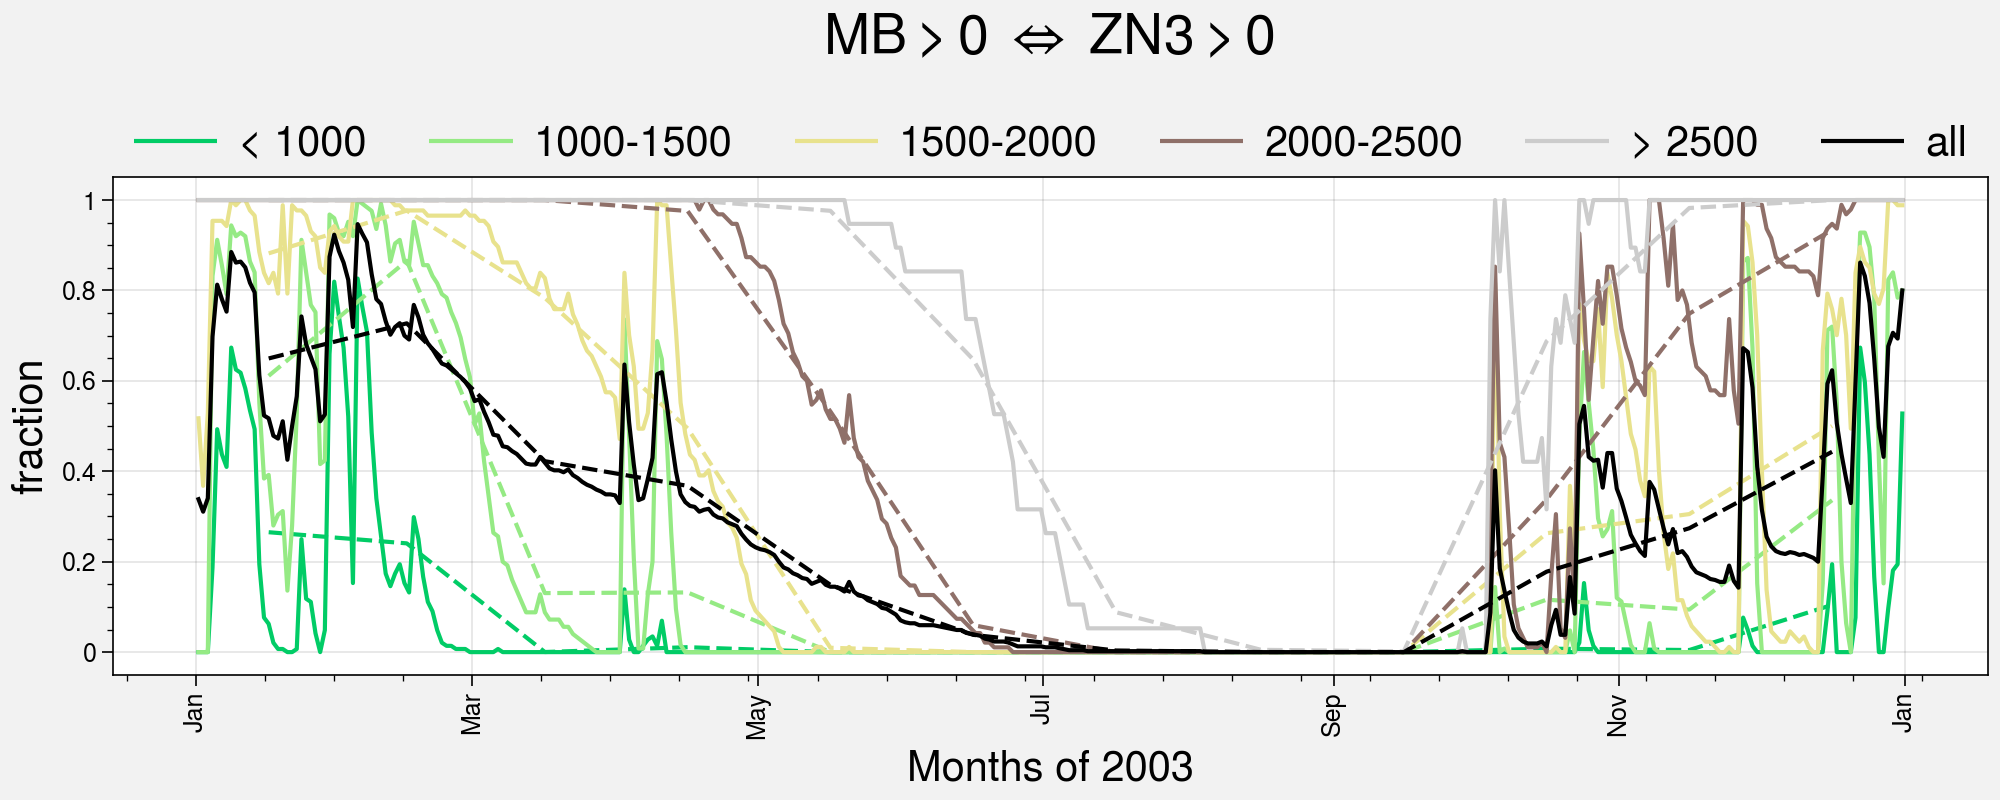

In [8]:
year=2003
# path = '/bettik/beaumetj/MARout/MAR-MPI-ESM1-2-HR/HIST/daily/ICE.MPI-ESM_HIST.EUy.'
path = '/bettik/beaumetj/MARout/MAR-ERA5/daily/ICE.ERA5_v1.EUl.'
MB = xr.open_mfdataset(path+'MB.'+str(year)+'.nc').MB[:,0,jmin:jmax,imin:imax]
ZN3 = xr.open_mfdataset(path+'ZN3.'+str(year)+'.nc').ZN3[:,0,jmin:jmax,imin:imax]

def plot_daily_monthly_levels(data,title='',unit=''):
    f,ax = pplt.subplots(figsize=(10,4))
    hs=[]
    for i,lev in enumerate(levels):
        frac_lev = 1/np.sum(levels[i])*np.sum(np.array(data).reshape(len(MB.time),nlon*nlat)[:,levels[i].reshape(nlon*nlat)],axis=1)
        h, = ax.plot(MB.time,frac_lev,color=color_levels[i],label=name_levels[i])

        monthly_frac_lev = 1/np.sum(levels[i])*np.sum(np.array((data).groupby("time.month").mean("time")).reshape(12,nlon*nlat)[:,levels[i].reshape(nlon*nlat)],axis=1)
        ax.plot(MB.time.groupby("time.month").mean("time"),monthly_frac_lev,'--',color=color_levels[i])
        hs.append(h)
    ax.set_ylabel(unit,fontsize=15)
    ax.xaxis.set_major_formatter(DateFormatter("%b"))
    ax.set_xlabel('Months of '+str(year),fontsize=15)
    ax.set_title(title,fontsize=20)
    ax.legend(hs, ncols=len(levels), center=True, frame=False, loc='t',fontsize=15)
plot_daily_monthly_levels(MB,title='MB',unit='mmWe')
plot_daily_monthly_levels(ZN3,title='ZN3',unit='m')
plot_daily_monthly_levels(MB>0,title='$MB>0 \\ \\Leftrightarrow \\ ZN3>0$ ',unit='fraction')
# plot_daily_monthly_levels(ZN3>0,title='ZN3>0',unit='fraction')

In [9]:
first_year = 1961
last_year = 2100
monthly_levels_data = np.zeros(((last_year-first_year+1),12,len(levels),7))

# snow_cover_levels = np.zeros((51133,len(levels)))
for year in list(range(first_year,last_year+1)):
    print(year,end=' ')
    if year <2015:
        # path = '/bettik/beaumetj/MARout/MAR-EC-Earth3/HIST/daily/ICE.EC-Earth3_HIST.EUe.'
        path = '/bettik/beaumetj/MARout/MAR-MPI-ESM1-2-HR/HIST/daily/ICE.MPI-ESM_HIST.EUy.'
    else:
        # path = '/bettik/beaumetj/MARout/MAR-MPI-ESM1-2-HR/SSP245/daily/ICE.MPI-ESM_SSP245.EUv.'
        # path = '/bettik/beaumetj/MARout/MAR-EC-Earth3/SSP245/daily/ICE.EC-Earth3_SSP245.EUe.'
        path = '/bettik/beaumetj/MARout/MAR-MPI-ESM1-2-HR/SSP585/daily/ICE.MPI-ESM_SSP585.EUy.'
        
    MB = xr.open_dataset(path+'MB.'+str(year)+'.nc').MB[:,0,jmin:jmax,imin:imax]
    SC = xr.open_dataset(path+'MB.'+str(year)+'.nc').MB[:,0,jmin:jmax,imin:imax] > 0
    SF = xr.open_dataset(path+'MBsf.'+str(year)+'.nc').MBsf[:,jmin:jmax,imin:imax]
    R = xr.open_dataset(path+'MBrr.'+str(year)+'.nc').MBrr[:,jmin:jmax,imin:imax]
    T = xr.open_dataset(path+'TTz.'+str(year)+'.nc').TTz[:,0,jmin:jmax,imin:imax]
    Tmax = xr.open_dataset(path+'TTmax.'+str(year)+'.nc').TTmax[:,0,jmin:jmax,imin:imax]
    Tmin = xr.open_dataset(path+'TTmin.'+str(year)+'.nc').TTmin[:,0,jmin:jmax,imin:imax]     
    
    MB_flat = np.array(MB.groupby("time.month").mean("time")).reshape(12,nlon*nlat)
    SC_flat = np.array(SC.groupby("time.month").mean("time")).reshape(12,nlon*nlat)
    SF_flat = np.array(SF.groupby("time.month").mean("time")).reshape(12,nlon*nlat)
    R_flat = np.array(R.groupby("time.month").mean("time")).reshape(12,nlon*nlat)
    T_flat = np.array(T.groupby("time.month").mean("time")).reshape(12,nlon*nlat)
    Tmax_flat = np.array(Tmax.groupby("time.month").max("time")).reshape(12,nlon*nlat)
    Tmin_flat = np.array(Tmin.groupby("time.month").min("time")).reshape(12,nlon*nlat)
                               
    iyear = year-first_year
    for i,lev in enumerate(levels):
        flat_lev = lev.reshape(nlon*nlat)
        monthly_levels_data[iyear,:,i,0] = np.sum( SC_flat[:,flat_lev] ,axis=1) /surface_levels[i]
        monthly_levels_data[iyear,:,i,1] = np.sum( SF_flat[:,flat_lev] ,axis=1) /surface_levels[i]
        monthly_levels_data[iyear,:,i,2] = np.sum( R_flat[:,flat_lev] ,axis=1) /surface_levels[i]
        monthly_levels_data[iyear,:,i,3] = np.sum( T_flat[:,flat_lev] ,axis=1) /surface_levels[i]
        monthly_levels_data[iyear,:,i,4] = np.sum( Tmax_flat[:,flat_lev] ,axis=1) /surface_levels[i]
        monthly_levels_data[iyear,:,i,5] = np.sum( Tmin_flat[:,flat_lev] ,axis=1) /surface_levels[i]
        monthly_levels_data[iyear,:,i,6] = np.sum( MB_flat[:,flat_lev] ,axis=1) /surface_levels[i]
        
    #if year%10==0:
        #np.save('/home/philinat/Stage-M2/saved_monthly_levels_data/monthly_levels_data_MPI85_french.npy', monthly_levels_data)
        # np.save('/home/philinat/Stage-M2/saved_monthly_levels_data/monthly_levels_data_ECE45.npy', monthly_levels_data)

1961 1962 1963 1964 1965 1966 1967 1968 1969 1970 

PermissionError: [Errno 13] Permission denied: '/home/philinat/Stage-M2/saved_monthly_levels_data/monthly_levels_data_MPI85_french.npy'

In [ ]:
monthly_levels_data = np.load('/home/philinat/Stage-M2/saved_monthly_levels_data/monthly_levels_data_MPI85_french.npy')
name_data = ['Snow cover','Snow fall (mm)','Rain (mm)','Mean T (°C)','Max T (°C)','Min T (°C)','Snow pack (mmWe)']

In [ ]:
fig,axs = pplt.subplots(nrows=7,figsize=(12,20))
time = np.linspace(1961,2101,140*12,endpoint=False)
y1,yn = 135,140
for j in range(monthly_levels_data.shape[3]):
    for i in range(len(levels)):
        axs[j].plot(time[y1*12:yn*12],monthly_levels_data[y1:yn,:,i,j].flatten(),color=color_levels[i])
    axs[j].set_title(name_data[j],fontsize=15)

In [ ]:
time = np.linspace(1961,2100,140)
y1,yn = 0,140
for m,month in enumerate(['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']):
    fig,axs = pplt.subplots(nrows=5,figsize=(12,8))# ,hratios=(1, 1,1,1) )
    for j,v in enumerate([1,0,3,4,5]):
        for i in range(len(levels)):#
            axs[j].plot(time[y1:yn],monthly_levels_data[y1:yn,m,i,v],color=color_levels[i])
            a, b, c = np.polyfit(time[y1:yn],monthly_levels_data[y1:yn,m,i,v], 2)
            # axs[j].plot(time[y1:yn], a*time[y1:yn] + b,'--',color=color_levels[i])
            axs[j].plot(time[y1:yn], a*time[y1:yn]**2 + b*time[y1:yn] +c,'--',color=color_levels[i])
        axs[j].set_title(name_data[v],fontsize=15)
        # x= np.linspace(np.min(p),np.max(p),2)
        # 
    fig.suptitle(month,fontsize=20)

In [ ]:
time = np.linspace(1961,2100,140)
y1,yn = 60,140
months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
fig,axs = pplt.subplots(nrows=3,ncols=2,figsize=(12,6), share=False)# ,hratios=(1, 1,1,1) )
for col in range(2):
    for j,v in enumerate([[3,4,5],[0,1,2]][col]):
        for i in range(len(levels)):
            les_delta = np.zeros(12)#len(levels),
            for m,month in enumerate(months):
                if v==2:
                    a, _ = np.polyfit(time[y1:yn],monthly_levels_data[y1:yn,m,i,1]+monthly_levels_data[y1:yn,m,i,2], 1)
                else:
                    a, _ = np.polyfit(time[y1:yn],monthly_levels_data[y1:yn,m,i,v], 1)
                les_delta[m] = a*80
            axs[j,col].plot(months,les_delta,color=color_levels[i])
        axs[j,col].set_title(name_data[v],fontsize=15)
        if v==2:
            axs[j,col].set_title('Rain+Snowfall (mm/d)',fontsize=15)
        if col==0:
            axs[j,col].set_ylim([0,8])
        # else:
        #     axs[j,col].set_ylim([-1,1])

fig.suptitle('French alps climate variations from 2020 to 2100 MAR-MPI',fontsize=20)
fig.legend(handles=[ mpatches.Patch(color=color_levels[i],label=name_levels[i]) for i in range(6)],
          fontsize=15, ncols=6, center=True, frame=False, loc='b')